In [17]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)
from boostvqe.models.dbi.utils import *
from boostvqe.models.dbi.utils_scheduling import *
from boostvqe.models.dbi.utils_dbr_strategies import *

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

In [18]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

In [19]:
def s_to_plot(s_list):
    s_plot = [0]*(len(s_list)+1)
    for i in range(len(s_list)):
        s_plot[i+1] = s_plot[i] + s_list[i]
    return s_plot

In [90]:
nqubits = 5
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
dbi = DoubleBracketIteration(hamiltonian=hamiltonian)

17.88854381999832


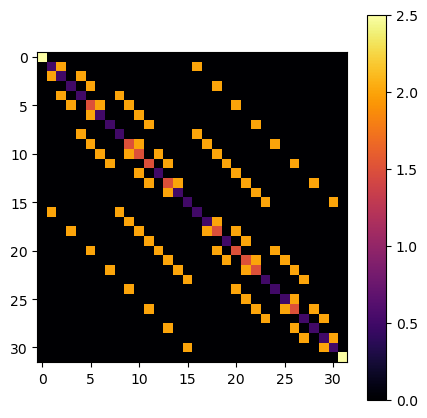

In [91]:
visualize_matrix(dbi.h.matrix)
print(dbi.off_diagonal_norm)

# Cost functions

In [100]:
# Here, we wish to show how different cost function can lead to different trajectory of diagonalization
cost_functions = [DoubleBracketCostFunction.off_diagonal_norm,
                  DoubleBracketCostFunction.energy_fluctuation,
                  DoubleBracketCostFunction.least_squares]
scheduling_function = DoubleBracketScheduling.binary_search
dbi.ref_state = np.zeros(2**nqubits)
dbi.ref_state[3] = 1
NSTEPS = 6
off_loss_list = []
ls_loss_list = []

s_list = []
for cost in cost_functions:
    dbi_eval = deepcopy(dbi)
    dbi_eval.cost = cost
    dbi_eval.scheduling = scheduling_function
    # d = np.diag(np.linspace(1,2**nqubits,2**nqubits))/2**nqubits
    d = dbi_eval.diagonal_h_matrix
    off_loss_ls = [dbi_eval.off_diagonal_norm]
    ls_loss_ls = [dbi_eval.least_squares(d=d)]
    print(dbi_eval.least_squares(d=d))
    s_ls = []
    for _ in range(NSTEPS):
        s = dbi_eval.choose_step(d=d, s_min=1e-3, s_max=1e-1)
        s_ls.append(s)
        dbi_eval(step=s, d=d)
        off_loss_ls.append(dbi_eval.off_diagonal_norm)
        ls_loss_ls.append(dbi_eval.least_squares(d=d))
    off_loss_list.append(off_loss_ls)
    ls_loss_list.append(ls_loss_ls)
    s_list.append(s_ls)

-19.999999999999996
-19.999999999999996
-19.999999999999996


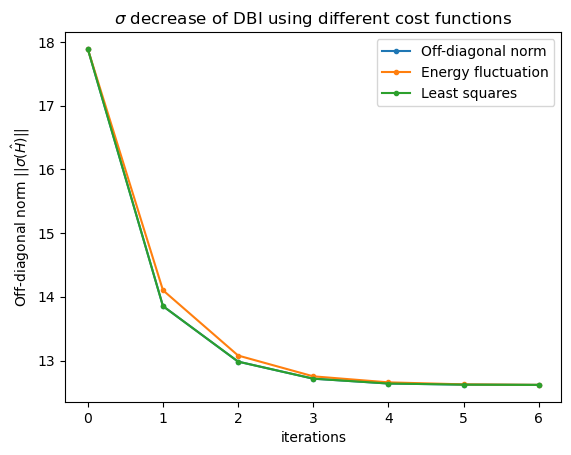

In [101]:
cost_names = ['Off-diagonal norm', 'Energy fluctuation', 'Least squares']
for i,cost in enumerate(cost_functions):
    plt.plot( off_loss_list[i], label=cost_names[i], marker='.')
plt.legend()
plt.ylabel(r'Off-diagonal norm $||\sigma(\hat H)||$')
# plt.xlabel(r'step duration $s$')
plt.xlabel('iterations')
plt.title(r"$\sigma$ decrease of DBI using different cost functions")
plt.savefig('cost_functions.pdf')

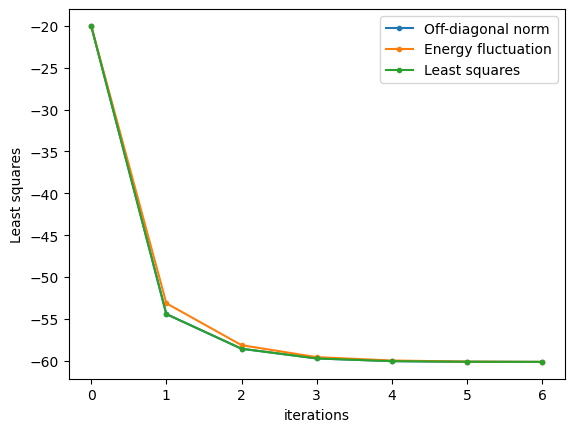

In [102]:
cost_names = ['Off-diagonal norm', 'Energy fluctuation', 'Least squares']
for i,cost in enumerate(cost_functions):
    plt.plot( ls_loss_list[i], label=cost_names[i], marker='.')
plt.legend()
plt.ylabel(r'Least squares')
# plt.xlabel(r'step duration $s$')
plt.xlabel('iterations')
plt.savefig('cost_functions.pdf')

# Scheduling methods

In [64]:
# sweep
s_space = np.linspace(1e-3, 3e-1, 60)
loss_ls = []
for s in s_space:
    loss_ls.append(dbi.loss(step=s, d=dbi.diagonal_h_matrix))

In [65]:
derivative_coef = off_diagonal_norm_polynomial_expansion_coef(dbi, dbi.diagonal_h_matrix, n=3)
print(derivative_coef)

[(4805973.333333333+0j), (368640+0j), (-35840+0j), (-1280+0j)]


0.0930210074190587


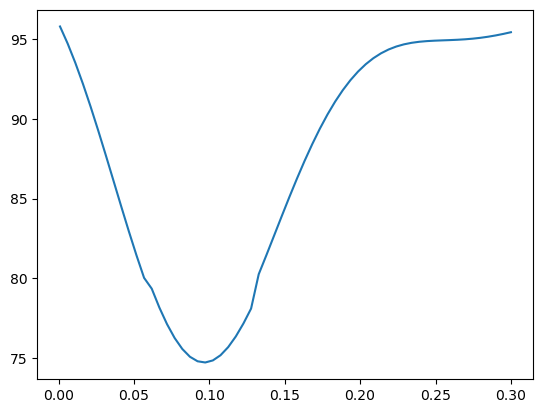

In [119]:
nqubits = 9
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
dbi = DoubleBracketIteration(hamiltonian=hamiltonian)
print(polynomial_step(dbi, n=10))

# sweep
s_space = np.linspace(1e-3, 3e-1, 60)
loss_ls = []
for s in s_space:
    loss_ls.append(dbi.loss(step=s, d=dbi.diagonal_h_matrix))

plt.plot(s_space,loss_ls)

In [ ]:
np.index()

In [66]:
# Marek's equation f'(0) = -2Tr([D, H], [\Delta(H), H])
W = dbi.commutator(dbi.diagonal_h_matrix, dbi.h.matrix)
W_can = dbi.commutator(dbi.diagonal_h_matrix, dbi.h.matrix)
derivative = -2 * np.trace(np.conjugate(W).T @ W_can)
print(derivative)

(-1280+0j)


/Users/pethidine/anaconda3/envs/DBF_qibo/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/pethidine/anaconda3/envs/DBF_qibo/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Loss function landscape')

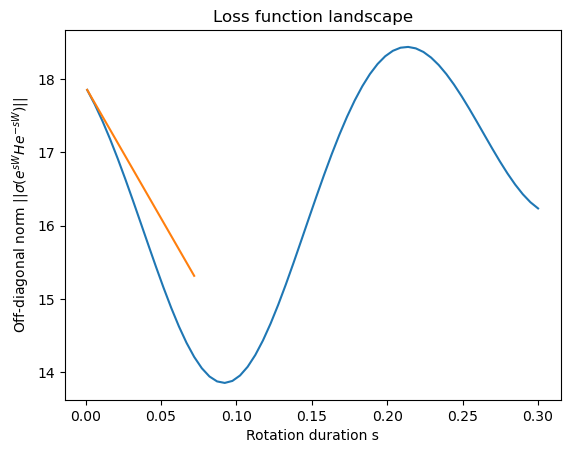

In [67]:
plt.plot(s_space, loss_ls)
plt.plot(s_space[:15], [s*derivative_coef[-1]/2/dbi.off_diagonal_norm+dbi.off_diagonal_norm for s in s_space][:15])
plt.xlabel("Rotation duration s")
plt.ylabel(r"Off-diagonal norm $||\sigma(e^{sW}He^{-sW})||$")
plt.title("Loss function landscape")

In [68]:
# polynomial fit
poly_fit_ls = []
n_ls = [2,8,10]
for n in n_ls:
    coef = np.real(off_diagonal_norm_polynomial_expansion_coef(dbi, d=dbi.diagonal_h_matrix, n=n))
    coef_int = [c/(i+1) for i,c in enumerate(reversed(coef))]
    poly_fit_ls.append([np.sqrt(sum(c*s**(i+1) for i,c in enumerate(coef_int))+dbi.off_diagonal_norm**2) for s in s_space])
    print(polynomial_step(dbi, n=n, d=dbi.diagonal_h_matrix, n_max=10))
    # print(np.roots(coef))
    # a lot of times polynomial fits but no solution to the minimum

0.12499999999999999
0.0914867731818969
0.09189340369167501


/var/folders/sn/4ym_qb8x0cs_f961d78kvvkc0000gn/T/ipykernel_36078/1863052731.py:7: RuntimeWarning: invalid value encountered in sqrt
  poly_fit_ls.append([np.sqrt(sum(c*s**(i+1) for i,c in enumerate(coef_int))+dbi.off_diagonal_norm**2) for s in s_space])


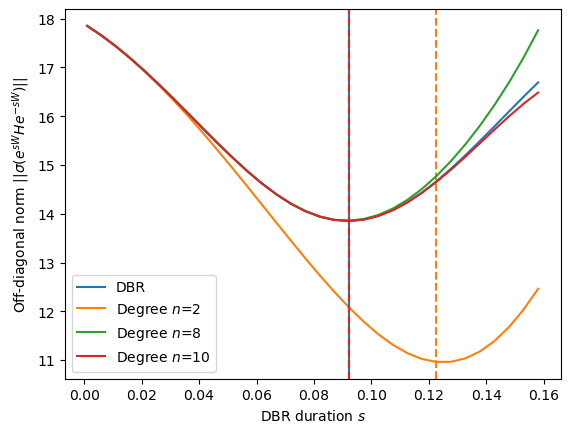

In [73]:
crop_iter = 32
colors = plt.get_cmap('tab10').colors
plt.plot(s_space[:crop_iter], loss_ls[:crop_iter], label="DBR")
plt.axvline(s_space[loss_ls.index(min(loss_ls[:crop_iter]))])
for i,n in enumerate(n_ls):
    color = colors[(i+1) % len(colors)]
    plt.plot(s_space[:crop_iter], poly_fit_ls[i][:crop_iter], label=f"Degree $n$={n}", color=color)
    plt.axvline(s_space[poly_fit_ls[i].index(min(poly_fit_ls[i][:crop_iter]))], color=color, linestyle='--')
plt.legend()
plt.xlabel(r"DBR duration $s$")
plt.ylabel(r"Off-diagonal norm $||\sigma(e^{sW}He^{-sW})||$")
plt.savefig("polynomial_fit.pdf")

## [ISSUE] Modified scheduling methods for more info

In [31]:
def adaptive_binary_step_mod(dbi_object, d, goal, threshold=1e-4, a=0, b=2, max_eval=10):
    evaluated_points = {}
    eval_count = {}
    delta_loss = float("inf")
    loss_func = lambda s: dbi_object.loss(d=d, step=s)

    def eval_func_at_points(eval_points):
        for point in eval_points:
            if point in evaluated_points.keys():
                val = evaluated_points[point]
            else:
                val = loss_func(point)
                evaluated_points[point] = val
        len(evaluated_points.values())

    grid = (b - a) / 2
    eval_points = [a, a + grid, b]
    eval_func_at_points(eval_points)

    while True:
        eval_vals = list(evaluated_points.values())
        eval_grid = list(evaluated_points.keys())
        loss_0 = min(eval_vals)
        ind_min_val = np.argmin(eval_vals)

        if eval_grid[ind_min_val] == min(eval_grid):
            a = a - grid
            eval_func_at_points([a])
        elif eval_grid[ind_min_val] == max(eval_grid):
            b = b + grid
            eval_func_at_points([b])
        else:
            break
    while True:
        eval_vals = list(evaluated_points.values())
        eval_grid = list(evaluated_points.keys())
        loss_0 = min(eval_vals)
        ind_min_val = np.argmin(eval_vals)

        # delta_loss = min(
        #     [abs(loss_0 - v) for i, v in enumerate(eval_vals) if i != ind_min_val]
        # )
        delta_loss = abs(eval_grid[ind_min_val] - goal)
        if len(evaluated_points.values()) > max_eval:
            exit_criterion = "max_evals"
            break
        if delta_loss < threshold:
            exit_criterion = "tolerance achieved"
            break

        grid /= 2
        eval_points = [eval_grid[ind_min_val] - grid, eval_grid[ind_min_val] + grid]
        eval_func_at_points(eval_points)

    return eval_grid[ind_min_val], len(evaluated_points), exit_criterion

In [51]:
def simulated_annealing_step_mod(
    dbi_object,
    s_goal, 
    threshold,
    d: Optional[np.array] = None,
    initial_s=None,
    step_min=1e-5,
    step_max=1,
    s_jump_range=None,
    s_jump_range_divident=5,
    initial_temp=1,
    cooling_rate=0.85,
    min_temp=1e-5,
    max_iter=200,
):
    """
    Perform a single step of simulated annealing optimization.

    Parameters:
        dbi_object: DBI object
            The object representing the problem to be optimized.
        d: Optional[np.array], optional
            The diagonal matrix 'd' used in optimization. If None, it uses the diagonal
            matrix 'diagonal_h_matrix' from dbi_object.
        initial_s: float or None, optional
            Initial value for 's', the step size. If None, it is initialized using
            polynomial_step function with 'n=4'. If 'polynomial_step' returns None,
            'initial_s' is set to 'step_min'.
        step_min: float, optional
            Minimum value for the step size 's'.
        step_max: float, optional
            Maximum value for the step size 's'.
        s_jump_range: float or None, optional
            Range for the random jump in step size. If None, it's calculated based on
            'step_min', 'step_max', and 's_jump_range_divident'.
        s_jump_range_divident: int, optional
            Dividend to determine the range for random jump in step size.
        initial_temp: float, optional
            Initial temperature for simulated annealing.
        cooling_rate: float, optional
            Rate at which temperature decreases in simulated annealing.
        min_temp: float, optional
            Minimum temperature threshold for termination of simulated annealing.
        max_iter: int, optional
            Maximum number of iterations for simulated annealing.

    Returns:
        float:
            The optimized step size 's'.
    """

    if d is None:
        d = dbi_object.diagonal_h_matrix
    if initial_s is None:
        initial_s = polynomial_step(dbi_object=dbi_object, d=d, n=4)
        # TODO: implement test to catch this if statement
        if initial_s is None:  # pragma: no cover
            initial_s = step_min
    if s_jump_range is None:
        s_jump_range = (step_max - step_min) / s_jump_range_divident
    current_s = initial_s
    current_loss = dbi_object.loss(d=d, step=current_s)
    temp = initial_temp

    for _ in range(max_iter):
        candidate_s = max(
            step_min,
            min(
                current_s + np.random.uniform(-1 * s_jump_range, s_jump_range), step_max
            ),
        )
        candidate_loss = dbi_object.loss(d=d, step=candidate_s)

        # Calculate change in loss
        delta_loss = candidate_loss - current_loss

        # Determine if the candidate solution is an improvement
        if delta_loss < 0 or np.random.rand() < math.exp(-delta_loss / temp):
            current_s = candidate_s
            current_loss = candidate_loss
        # Cool down
        temp *= cooling_rate
        if temp < min_temp or current_s > step_max or current_s < step_min:
            print("temp reached")
            break
        if abs(current_s - s_goal)<threshold:
            print("threshold met")
            break

    return current_s, _

In [52]:
# test of other scheduling methods
nqubit_ls = [5]
threshold = 1e-4
for nqubits in nqubit_ls:
    hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
    dbi = DoubleBracketIteration(hamiltonian=hamiltonian)
    s_poly = polynomial_step(dbi, d=dbi.diagonal_h_matrix, n=5)
    s_goal = grid_search_step(dbi, d=dbi.diagonal_h_matrix, num_evals=200, step_min=s_poly*0.6, step_max=s_poly*1.4)
    print(s_goal)
    eval_points = adaptive_binary_step_mod(dbi, dbi.diagonal_h_matrix, s_goal, threshold, b=1e-1, max_eval=100)
    print("binary", eval_points)
    s, eval_points = simulated_annealing_step_mod(dbi, s_goal, threshold,dbi.diagonal_h_matrix)
    print("SA", s, eval_points)
    # Don't know how to evluate for hyperopt
    

0.09173260470747066
binary (0.091796875, 18, 'tolerance achieved')
threshold met
SA 0.09170531376984194 32


# DBR generator selection task

## BHMM

## Variational

In [11]:
nqubits_ls = [5,7]
NSTEPS = 3

In [12]:
# canonical
for nqubits in nqubits_ls:
    print(nqubits)
    hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
    dbi = DoubleBracketIteration(hamiltonian=hamiltonian)
    print("norm", dbi.off_diagonal_norm)
    for _ in range(NSTEPS):
        reference = polynomial_step(dbi, d=dbi.diagonal_h_matrix, n=6)
        print("reference", reference)
        if reference is None or reference > 5e-1:
            reference = 0.05
        results = adaptive_binary_search(lambda s: dbi.loss(d=dbi.diagonal_h_matrix, step=s), a=0.5*reference, b=1.5*reference, max_eval=20)
        print("s", results[0])
        dbi(step=results[0], d=dbi.diagonal_h_matrix)
        print("norm", dbi.off_diagonal_norm)
        

5
norm 17.88854381999832
reference 0.09678063269800984
s 0.0914879418473374
norm 13.852445065748066
reference 0.028099946300209122
s 0.028099946300209122
norm 12.979062091786354
reference 0.04298434492216931
s 0.04298434492216931
norm 12.706286537836144
7
norm 42.33202097703345
reference 0.10364733812786771
s 0.09271578293469417
norm 32.94053710296554
reference 0.02265761975519111
s 0.022657619755191115
norm 29.09948881732532
reference 0.018344483540955168
s 0.01834448354095517
norm 26.855405745134814


In [ ]:
# 1-local
